In [1]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

from xgboost import XGBRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/My Drive/Colab_Notebooks/project_ds/laptop_merge_v2.csv'
df = pd.read_csv(file_path)


Checking for NaN values in input features:
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best parameters for RandomForest (Cores): {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best CV MAE for RandomForest (Cores): 0.864
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Best parameters for XGBoost (Cores): {'regressor__colsample_bytree': 0.9, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 9, 'regressor__n_estimators': 400, 'regressor__reg_lambda': 0.1, 'regressor__subsample': 0.7}
Best CV MAE for XGBoost (Cores): 0.487

Selected best model for CPU Cores: XGBoost
Test MAE cpu_cores: 0.023
✅ Đã điền giá trị dự đoán cho 160 dòng bị thiếu trong df_copy (cpu_cores).
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best parameters for RandomForest (Threads): {'regressor__max_depth': None, 'regressor__max_features':

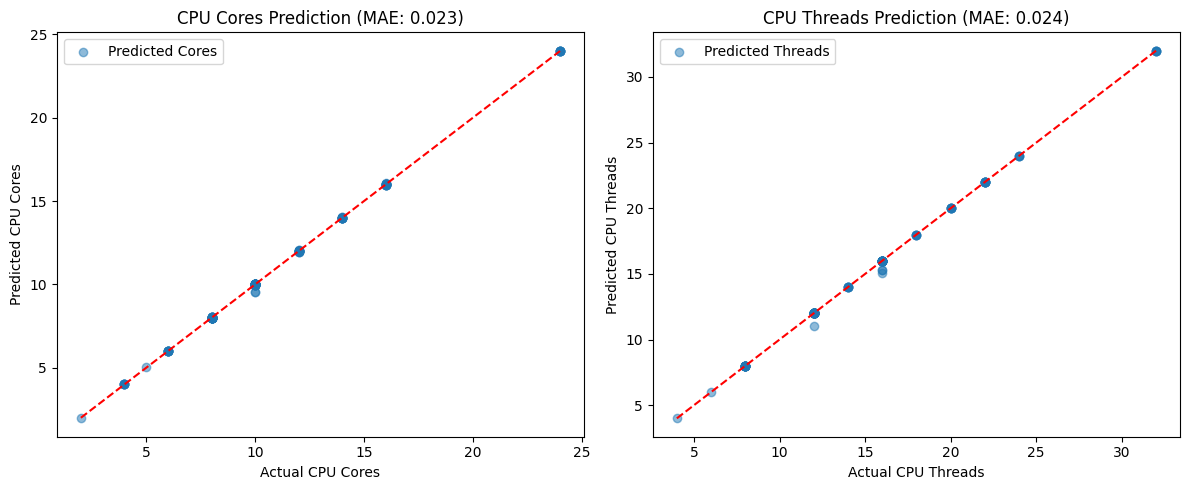

Baseline MAE cpu_cores: 3.162
Baseline MAE cpu_threads: 3.887


In [ ]:
# === FEATURE ENGINEERING ===
def add_cpu_features_enhanced(df):
    df = df.copy()

    # Binary features for CPU types based on cpu_series
    df['is_i3'] = df['cpu_series'].str.contains('i3|core 3', case=False, na=False).astype(int)
    df['is_i5'] = df['cpu_series'].str.contains('i5|core 5|core ultra 5', case=False, na=False).astype(int)
    df['is_i7'] = df['cpu_series'].str.contains('i7|core 7|core ultra 7', case=False, na=False).astype(int)
    df['is_i9'] = df['cpu_series'].str.contains('i9|core ultra 9|raptor lake i9', case=False, na=False).astype(int)
    df['is_ryzen_3'] = df['cpu_series'].str.contains('ryzen 3', case=False, na=False).astype(int)
    df['is_ryzen_5'] = df['cpu_series'].str.contains('ryzen 5|ryzen ai 5', case=False, na=False).astype(int)
    df['is_ryzen_7'] = df['cpu_series'].str.contains('ryzen 7|ryzen ai 7|ryzen r7', case=False, na=False).astype(int)
    df['is_ryzen_9'] = df['cpu_series'].str.contains('ryzen 9|ryzen ai 9', case=False, na=False).astype(int)
    df['is_apple_m'] = df['cpu_series'].str.contains('m1|m2|m3|m4', case=False, na=False).astype(int)
    df['is_snapdragon'] = df['cpu_series'].str.contains('snapdragon', case=False, na=False).astype(int)
    df['is_celeron'] = df['cpu_series'].str.contains('celeron', case=False, na=False).astype(int)
    df['is_pentium'] = df['cpu_series'].str.contains('pentium', case=False, na=False).astype(int)

    # Extract CPU generation (e.g., "10th Gen")
    df['cpu_generation'] = df['cpu_series'].str.extract(r'(\d+th Gen|\d+rd Gen|\d+nd Gen|\d+st Gen)', expand=False)
    df['cpu_generation'] = df['cpu_generation'].fillna('Unknown')

    # Extract CPU model number (e.g., "7700U")
    df['cpu_model_number'] = df['cpu_series'].str.extract(r'(\d+[A-Z]+)', expand=False)
    df['cpu_model_number'] = df['cpu_model_number'].fillna('Unknown')

    # Boolean features for specific keywords
    df['is_xeon'] = df['cpu_series'].str.contains('xeon', case=False, na=False).astype(int)
    df['is_ryzen_pro'] = df['cpu_series'].str.contains('ryzen pro', case=False, na=False).astype(int)

    return df

# Apply the enhanced CPU feature engineering
df_copy = add_cpu_features_enhanced(df.copy())

def categorize_ram(ram_storage):
    if ram_storage <= 4:
        return '4'
    elif ram_storage <= 8:
        return '8'
    elif ram_storage <= 16:
        return '16'
    elif ram_storage <= 32:
        return '32'
    else:
        return '64+'

df_copy['ram_storage'] = df_copy['ram_storage'].apply(categorize_ram)

# ==== CÁC CỘT ====
binary_columns = [
    'hoc_tap_van_phong', 'laptop_sang_tao_noi_dung', 'mong_nhe',
    'gaming', 'do_hoa_ky_thuat', 'cao_cap_sang_trong',
    'is_i3', 'is_i5', 'is_i7', 'is_i9', 'is_ryzen_3', 'is_ryzen_5',
    'is_ryzen_7', 'is_ryzen_9', 'is_apple_m', 'is_snapdragon', 'is_celeron', 'is_pentium',
    'is_xeon', 'is_ryzen_pro'
]
cat_columns = ['cpu_model', 'cpu_series', 'cpu_brand', 'cpu_generation', 'cpu_model_number', 'ram_storage']
num_columns = [col for col in ['display_size'] if col in df_copy.columns]
target_columns = ['cpu_cores', 'cpu_threads']

# ==== DATA VALIDATION ====
print("\nChecking for NaN values in input features:")
for col in cat_columns + binary_columns + num_columns:
    if col in df_copy.columns:
        nan_count = df_copy[col].isna().sum()
        if nan_count > 0:
            print(f"Column '{col}' has {nan_count} NaN values")

# ==== 1. TÁCH DỮ LIỆU ====
train_full = df_copy.dropna(subset=target_columns)
predict_df = df_copy[df_copy[target_columns].isna().any(axis=1)]

# Tách riêng dữ liệu để dự đoán cpu_cores và cpu_threads
train_cores = train_full.dropna(subset=['cpu_cores'])
train_threads = train_full.dropna(subset=['cpu_threads'])

predict_cores = df_copy[df_copy['cpu_cores'].isna()].copy()
predict_threads = df_copy[df_copy['cpu_threads'].isna()].copy()

X_train_cores = train_cores[cat_columns + binary_columns + num_columns]
y_train_cores = train_cores['cpu_cores']
X_test_cores = X_train_cores.sample(frac=0.2, random_state=42)  # Create a test set for cpu_cores
y_test_cores = y_train_cores.loc[X_test_cores.index]  # Corresponding target values

# ==== 2. TIỀN XỬ LÝ ====
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_columns),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  # Scale numerical features
        ]), num_columns)
    ],
    remainder='passthrough'
)

# ==== 3. PIPELINE VÀ TÌM SIÊU THAM SỐ TỐI ƯU (CPU CORES) ====
models_cores = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, enable_categorical=False)
}

param_grids_cores = {
    'RandomForest': {
        'regressor__n_estimators': [200, 300, 400],
        'regressor__max_depth': [10, 15, 20, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2],
        'regressor__max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'regressor__n_estimators': [200, 300, 400],
        'regressor__max_depth': [5, 7, 9],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__reg_lambda': [0.0, 0.1, 1.0],
        'regressor__subsample': [0.7, 0.8, 0.9],
        'regressor__colsample_bytree': [0.7, 0.8, 0.9]
    }
}

best_model_cores = None
best_score_cores = float('inf')
best_model_name_cores = None

for model_name, base_model in models_cores.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', base_model)
    ])

    grid_search = GridSearchCV(
        model,
        param_grids_cores[model_name],
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )

    try:
        grid_search.fit(X_train_cores, y_train_cores)
        mean_score = -grid_search.best_score_
        if mean_score < best_score_cores:
            best_score_cores = mean_score
            best_model_cores = grid_search.best_estimator_
            best_model_name_cores = model_name

        print(f"\nBest parameters for {model_name} (Cores): {grid_search.best_params_}")
        print(f"Best CV MAE for {model_name} (Cores): {mean_score:.3f}")
    except Exception as e:
        print(f"\nError fitting {model_name} (Cores): {e}")

# Lấy mô hình tốt nhất cho CPU Cores
if best_model_cores is None:
    print("No model was successfully fitted for CPU Cores. Check data for issues.")
    exit()

print(f"\nSelected best model for CPU Cores: {best_model_name_cores}")

# Đánh giá mô hình tốt nhất cho CPU Cores
y_pred_test_cores = best_model_cores.predict(X_test_cores)
mae_cores = mean_absolute_error(y_test_cores, y_pred_test_cores)
print(f"Test MAE cpu_cores: {mae_cores:.3f}")

# Dự đoán giá trị thiếu cho cpu_cores
if len(predict_cores) > 0:
    X_predict_cores = predict_cores[cat_columns + binary_columns + num_columns]
    predicted_cores = best_model_cores.predict(X_predict_cores)
    predicted_cores_rounded = np.round(predicted_cores)
    df_copy.loc[predict_cores.index, 'cpu_cores'] = predicted_cores_rounded
    print(f"✅ Đã điền giá trị dự đoán cho {len(predict_cores)} dòng bị thiếu trong df_copy (cpu_cores).")
else:
    print("Không có dòng thiếu cần dự đoán (cpu_cores).")

# ==== 3. PIPELINE VÀ TÌM SIÊU THAM SỐ TỐI ƯU (CPU THREADS) ====
# Chuẩn bị dữ liệu cho cpu_threads, sử dụng cpu_cores đã dự đoán
train_threads = df_copy.dropna(subset=['cpu_threads', 'cpu_cores'])
predict_threads = df_copy[df_copy['cpu_threads'].isna()].copy()

# Thêm 'cpu_cores' (đã dự đoán) vào features
features_threads = cat_columns + binary_columns + num_columns + ['cpu_cores']
X_train_threads = train_threads[features_threads]
y_train_threads = train_threads['cpu_threads']
X_test_threads = X_train_threads.sample(frac=0.2, random_state=42)
y_test_threads = y_train_threads.loc[X_test_threads.index]

preprocessor_threads = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_columns),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  # Scale numerical features
        ]), num_columns),
        ('passthrough', 'passthrough', ['cpu_cores'])  # Giữ 'cpu_cores' như một đặc trưng
    ],
    remainder='passthrough'
)

models_threads = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, enable_categorical=False)
}

param_grids_threads = {
    'RandomForest': {
        'regressor__n_estimators': [200, 300, 400],
        'regressor__max_depth': [10, 15, 20, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2],
        'regressor__max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'regressor__n_estimators': [200, 300, 400],
        'regressor__max_depth': [5, 7, 9],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__reg_lambda': [0.0, 0.1, 1.0],
        'regressor__subsample': [0.7, 0.8, 0.9],
        'regressor__colsample_bytree': [0.7, 0.8, 0.9]
    }
}

best_model_threads = None
best_score_threads = float('inf')
best_model_name_threads = None

for model_name, base_model in models_threads.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor_threads),
        ('regressor', base_model)
    ])

    grid_search = GridSearchCV(
        model,
        param_grids_threads[model_name],
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )

    try:
        grid_search.fit(X_train_threads, y_train_threads)
        mean_score = -grid_search.best_score_
        if mean_score < best_score_threads:
            best_score_threads = mean_score
            best_model_threads = grid_search.best_estimator_
            best_model_name_threads = model_name

        print(f"\nBest parameters for {model_name} (Threads): {grid_search.best_params_}")
        print(f"Best CV MAE for {model_name} (Threads): {mean_score:.3f}")
    except Exception as e:
        print(f"\nError fitting {model_name} (Threads): {e}")

# Lấy mô hình tốt nhất cho CPU Threads
if best_model_threads is None:
    print("No model was successfully fitted for CPU Threads. Check data for issues.")
    exit()

print(f"\nSelected best model for CPU Threads: {best_model_name_threads}")

# Đánh giá mô hình tốt nhất cho CPU Threads
y_pred_test_threads = best_model_threads.predict(X_test_threads)
mae_threads = mean_absolute_error(y_test_threads, y_pred_test_threads)
print(f"Test MAE cpu_threads: {mae_threads:.3f}")

# Dự đoán giá trị thiếu cho cpu_threads
if len(predict_threads) > 0:
    X_predict_threads = predict_threads[features_threads]
    predicted_threads = best_model_threads.predict(X_predict_threads)
    predicted_threads_rounded = np.round(predicted_threads)
    df_copy.loc[predict_threads.index, 'cpu_threads'] = predicted_threads_rounded
    print(f"✅ Đã điền giá trị dự đoán cho {len(predict_threads)} dòng bị thiếu trong df_copy (cpu_threads).")
else:
    print("Không có dòng thiếu cần dự đoán (cpu_threads).")


# Sau khi điền, điền giá trị null còn lại nếu có
median_cores = train_full['cpu_cores'].median()
median_threads = train_full['cpu_threads'].median()
df_copy['cpu_cores'] = df_copy['cpu_cores'].fillna(median_cores)
df_copy['cpu_threads'] = df_copy['cpu_threads'].fillna(median_threads)

# ==== 6. KIỂM TRA KẾT QUẢ ====
if mae_cores >= 1.0 or mae_threads >= 1.0:
    print("⚠️ MAE không đạt ngưỡng (< 1.0). Cân nhắc cải thiện mô hình hoặc thêm đặc trưng.")
if df_copy[target_columns].isna().any().any():
    print("⚠️ Vẫn còn giá trị null trong cpu_cores hoặc cpu_threads sau khi dự đoán.")

print("\nDữ liệu sau khi điền giá trị null trong df_copy:")
print(df_copy[['cpu_brand', 'cpu_model', 'cpu_series', 'cpu_cores', 'cpu_threads', 'url_path']])

print("\nCác dòng vẫn còn giá trị null trong df_copy:")
null_rows = df_copy[df_copy[['cpu_cores', 'cpu_threads']].isna().any(axis=1)]
print(null_rows[['cpu_brand', 'cpu_model', 'cpu_series', 'cpu_cores', 'cpu_threads', 'nhu_cau_su_dung']])

# ==== 7. VISUALIZATION ====
# (Để trực quan hoá, bạn cần điều chỉnh để phù hợp với việc dự đoán riêng rẽ)
# Ví dụ: Chỉ vẽ scatter plot cho cpu_cores và cpu_threads riêng rẽ

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_cores, y_pred_test_cores, alpha=0.5, label='Predicted Cores')
plt.plot([y_test_cores.min(), y_test_cores.max()], [y_test_cores.min(), y_test_cores.max()], 'r--')
plt.xlabel('Actual CPU Cores')
plt.ylabel('Predicted CPU Cores')
plt.title(f'CPU Cores Prediction (MAE: {mae_cores:.3f})')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_threads, y_pred_test_threads, alpha=0.5, label='Predicted Threads')
plt.plot([y_test_threads.min(), y_test_threads.max()], [y_test_threads.min(), y_test_threads.max()], 'r--')
plt.xlabel('Actual CPU Threads')
plt.ylabel('Predicted CPU Threads')
plt.title(f'CPU Threads Prediction (MAE: {mae_threads:.3f})')
plt.legend()

plt.tight_layout()
plt.show()

# Feature importance for RandomForest
# (Điều chỉnh để phù hợp với mô hình tốt nhất cho CPU Cores và CPU Threads)

# Baseline MAE
median_cores = train_full['cpu_cores'].median()
median_threads = train_full['cpu_threads'].median()
baseline_mae_cores = mean_absolute_error(y_test_cores, [median_cores] * len(y_test_cores))
baseline_mae_threads = mean_absolute_error(y_test_threads, [median_threads] * len(y_test_threads))
print(f"Baseline MAE cpu_cores: {baseline_mae_cores:.3f}")
print(f"Baseline MAE cpu_threads: {baseline_mae_threads:.3f}")

In [ ]:
from google.colab import files
df['cpu_cores'] = df_copy['cpu_cores']
df['cpu_threads'] = df_copy['cpu_threads']

In [ ]:
df.to_csv('laptop_merge_v3.csv', index=False)
files.download('laptop_merge_v3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.head()

,cam_ung,height_mm,url_path,material,storage_max_support,storage_gb,display_width,bluetooth_version,width_mm,manufacturer,...,vga_vram,laptop_camera,display_size,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,gaming,do_hoa_ky_thuat,cao_cap_sang_trong
0,0,227.0,https://www.thegioididong.com/laptop/asus-fa40...,vỏ nhựa - nắp lưng kim loại,2048.0,1024.0,2560.0,5.3,311.0,asus,...,8.0,full hd,14.0,amd,0,1,0,1,1,0
1,0,235.0,https://www.thegioididong.com/laptop/lenovo-id...,vỏ nhựa,1024.0,1024.0,1920.0,5.2,359.3,lenovo,...,NaN,hd,15.6,intel,1,0,0,1,1,0
2,0,237.5,https://www.thegioididong.com/laptop/acer-aspi...,vỏ nhựa,1024.0,512.0,1920.0,5.1,362.9,acer,...,NaN,hd,15.6,intel,1,0,0,0,0,1
3,0,232.5,https://www.thegioididong.com/laptop/asus-vivo...,vỏ nhựa,512.0,512.0,1920.0,5.3,359.7,asus,...,NaN,hd,15.6,intel,1,0,0,1,1,1
4,0,212.4,https://www.thegioididong.com/laptop/apple-mac...,vỏ kim loại,256.0,256.0,2560.0,5.0,304.1,apple,...,NaN,hd,13.3,apple,1,1,1,0,1,1


In [ ]:
file_path_1 = '/content/drive/My Drive/Colab_Notebooks/project_ds/general_info_v3.csv'
df_mannual = pd.read_csv(file_path_1)

In [ ]:
file_path_2 = '/content/drive/My Drive/Colab_Notebooks/project_ds/df_filled_output_2.csv'
df_api = pd.read_csv(file_path_2)

In [ ]:
print(df_api.columns.tolist())

['product_id', 'name', 'manufacturer', 'laptop_height_mm', 'laptop_width_mm', 'cpu_boost_clock_ghz', 'root_price_vnd', 'cpu_threads', 'cpu_cores', 'ram_speed', 'discounted_price_vnd', 'ram_type', 'refresh_rate_hz', 'cpu_base_clock_ghz', 'ram_slots', 'battery_capacity_wh', 'cpu_model', 'vga_type', 'laptop_depth_mm', 'vga_vram_gb', 'laptop_camera']


In [ ]:
# Merge df với df_api theo product_id
df_merged = df.merge(df_api[['product_id', 'cpu_cores']], on='product_id', how='inner', suffixes=('_x', '_y'))

# So sánh cpu_cores giữa 2 DataFrame sau khi merge
match_cpu_cores = df_merged['cpu_cores_x'] == df_merged['cpu_cores_y']

# Tính tỷ lệ trùng khớp (accuracy)
accuracy = match_cpu_cores.mean() * 100

print(f"Tỷ lệ trùng cpu_cores giữa df và df_api: {accuracy:.2f}%")

Tỷ lệ trùng cpu_cores giữa df và df_api: 95.27%


In [ ]:
# Merge df với df_api theo product_id
df_merged = df.merge(df_api[['product_id', 'cpu_threads']], on='product_id', how='inner', suffixes=('_x', '_y'))

# So sánh cpu_threads giữa 2 DataFrame sau khi merge
match_cpu_threads = df_merged['cpu_threads_x'] == df_merged['cpu_threads_y']

# Tính tỷ lệ trùng khớp (accuracy)
accuracy = match_cpu_threads.mean() * 100

print(f"Tỷ lệ trùng cpu_threads giữa df và df_api: {accuracy:.2f}%")

Tỷ lệ trùng cpu_threads giữa df và df_api: 64.73%
